# COVID-19 Detection Using Multi-Phase Training of ConvNets with Multi-Class Imbalanced Chest CT Scan Data

The main sections of the notebook are:

1. [Import Needed Libraries](#a)
2. [Logistic Regression](#b)
3. [Training with smotesampled Data](#c)
4. [Two-Phase Training with Undersampling](#d)
5. [Multi-Phase Training with Undersampling](#e)

<div style="text-align: right"> Ahmet Talha Yiğit / 507191101 </div>

<a id=’a’></a>
### 1. Import Needed Libraries

In [1]:
import numpy as np
import shap
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support,classification_report
from sklearn.metrics import average_precision_score,PrecisionRecallDisplay, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import PredefinedSplit,GridSearchCV
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE 
from imblearn.combine import SMOTEENN
import seaborn as sns

# Import needed packages for the model building and stage
#from skimage import io, transform
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils       
from torchvision.utils import make_grid
import torch.optim as optim

pd.set_option('display.max_columns', None)

c:\Users\ahmet\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def lift_scorer(target, pred_proba):
    
    df = pd.DataFrame(pred_proba)
    df.columns = ['pred_proba']
    df['target'] = target.values
    df['pred_proba_rank'] = df['pred_proba'].rank(ascending = False).astype(int)
    lift = round(df[df['pred_proba_rank'] <= round(df['pred_proba_rank'].max() * (1/100), 0)]['target'].sum() / df['target'].sum() * 100, 1)

    return lift

In [3]:
X_train = pd.read_pickle('./Data/X_train_preprocessed.pkl')
y_train = pd.read_pickle('./Data/y_train_preprocessed.pkl')
X_val = pd.read_pickle('./Data/X_val_preprocessed.pkl')
y_val = pd.read_pickle('./Data/y_val_preprocessed.pkl')
X_test = pd.read_pickle('./Data/X_test_preprocessed.pkl')
y_test = pd.read_pickle('./Data/y_test_preprocessed.pkl')
X_test_orig = pd.read_pickle('./Data/X_test_all_imputed.pkl')

In [4]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((60000, 33), (60000,), (7500, 33), (7500,), (7500, 33), (7500,))

In [5]:
X_train = X_train.reset_index()
y_train = y_train.reset_index()
X_val = X_val.reset_index()
y_val = y_val.reset_index()
X_test = X_test.reset_index()
y_test = y_test.reset_index()
X_test_orig = X_test_orig.reset_index()

X_train['idx'] = 'Train'
y_train['idx'] = 'Train'
X_val['idx'] = 'Val'
y_val['idx'] = 'Val'
X_test['idx'] = 'Test'
y_test['idx'] = 'Test'
X_test_orig['idx'] = 'Test'

X_train['index'] = X_train['index'].astype('str')
y_train['index'] = y_train['index'].astype('str')
X_val['index'] = X_val['index'].astype('str')
y_val['index'] = y_val['index'].astype('str')
X_test['index'] = X_test['index'].astype('str')
y_test['index'] = y_test['index'].astype('str')
X_test_orig['index'] = X_test_orig['index'].astype('str')

X_train['index'] = X_train[["index", "idx"]].apply("-".join, axis=1)
y_train['index'] = y_train[["index", "idx"]].apply("-".join, axis=1)
X_val['index'] = X_val[["index", "idx"]].apply("-".join, axis=1)
y_val['index'] = y_val[["index", "idx"]].apply("-".join, axis=1)
X_test['index'] = X_test[["index", "idx"]].apply("-".join, axis=1)
y_test['index'] = y_test[["index", "idx"]].apply("-".join, axis=1)
X_test_orig['index'] = X_test_orig[["index", "idx"]].apply("-".join, axis=1)

X_train = X_train.set_index('index')
y_train = y_train.set_index('index')
X_val = X_val.set_index('index')
y_val = y_val.set_index('index')
X_test = X_test.set_index('index')
y_test = y_test.set_index('index')
X_test_orig = X_test_orig.set_index('index')

X_train = X_train.drop('idx', axis = 1)
y_train = y_train.drop('idx', axis = 1)
X_val = X_val.drop('idx', axis = 1)
y_val = y_val.drop('idx', axis = 1)
X_test = X_test.drop('idx', axis = 1)
y_test = y_test.drop('idx', axis = 1)
X_test_orig = X_test_orig.drop('idx', axis = 1)

In [6]:
X_test_orig['Var_41'] = X_test_orig['Var_24'] + X_test_orig['Var_29'] + X_test_orig['Var_37']

In [7]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((60000, 33), (60000, 1), (7500, 33), (7500, 1), (7500, 33), (7500, 1))

In [8]:
X_train.head()

,Var_1,Var_2,Var_3,Var_4,Var_5,Var_6,Var_7,Var_8,Var_9,Var_10,Var_11,Var_12,Var_13,Var_14,Var_15,Var_18,Var_19,Var_20,Var_21,Var_22,Var_23,Var_25,Var_26,Var_27,Var_28,Var_30,Var_31,Var_33,Var_34,Var_36,Var_38,Var_39,Var_41
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
60075-Train,-0.109742,1.134404,-1.009085,-3.644704,-1.627865,-0.470549,0.480831,0.641715,0.194911,0.634267,-0.034149,-0.078538,-0.026559,-0.06627,0.517341,-2.315973,-0.271932,0.741682,-0.378395,-0.755951,-0.116982,-0.064629,0.619527,-0.144079,-0.247141,-0.249080,0.240094,-0.396241,-1.289230,-0.039831,-0.345385,-0.233373,-0.006544
27225-Train,-0.109742,0.075986,0.977945,-0.731477,-1.627865,-0.470549,0.480831,0.641715,0.194911,0.634267,1.962810,-0.078538,-0.026559,-0.06627,-1.932962,-2.315973,-0.271932,0.741682,-0.378395,-0.755951,-0.116982,-0.064629,-0.799346,-0.144079,-0.247141,-0.249080,0.240094,0.533820,0.640053,-0.039831,-0.345385,-0.233373,-0.006544
403-Train,-0.109742,0.075986,0.702450,-0.631123,0.562187,-0.470549,0.480831,0.641715,0.194911,0.634267,-0.245195,-0.078538,-0.026559,-0.06627,0.517341,0.391578,-1.571343,-0.254516,-0.378395,-0.755951,-0.116982,-0.064629,-0.628008,0.063240,-0.247141,4.014773,0.240094,2.491077,0.640053,-0.039831,-0.345385,-0.233373,-0.006544
27953-Train,-0.109742,-0.408430,0.702450,1.045385,0.613346,-0.470549,0.480831,0.641715,0.194911,0.634267,-0.537007,-0.078538,-0.026559,-0.06627,0.517341,0.585779,-0.271932,0.544290,0.401668,-0.755951,-0.116982,-0.064629,0.619527,0.063240,-0.247141,-0.249080,0.240094,0.169018,0.640053,-0.039831,-0.345385,-0.233373,-0.006544
74481-Train,-0.109742,-0.408430,0.702450,0.077261,1.008509,1.183906,0.480831,0.641715,0.194911,-1.576622,-0.154129,-0.078538,-0.026559,-0.06627,0.517341,0.805784,-0.271932,-0.733391,0.401668,-0.755951,-0.116982,-0.064629,0.619527,-0.144079,0.475470,-0.249080,0.240094,0.455636,0.640053,-0.039831,-0.345385,-0.233373,-0.006544


<a id=’b’></a>
## 5. LightGBM

In [9]:
classifier_base = LGBMClassifier(random_state = 102022)
classifier_tuned = LGBMClassifier(random_state = 102022, is_unbalance = True, learning_rate = 0.01, max_depth = 3, min_child_samples = 50, reg_alpha = 0.5, reg_lambda = 0.5)
classifier_resampled_tuned = LGBMClassifier(random_state = 102022, is_unbalance = True, learning_rate = 0.01, max_depth = 3, min_child_samples = 100, reg_alpha = 0.5, reg_lambda = 0.5)

resample = RandomUnderSampler(sampling_strategy = 0.05, random_state=102022)
X_resampled, y_resampled = resample.fit_resample(X_train, y_train)

classifier_base.fit(X_train, y_train.values.ravel())
classifier_tuned.fit(X_train, y_train.values.ravel())
classifier_resampled_tuned.fit(X_resampled, y_resampled.values.ravel())

LGBMClassifier(is_unbalance=True, learning_rate=0.01, max_depth=3,
               min_child_samples=100, random_state=102022, reg_alpha=0.5,
               reg_lambda=0.5)

In [10]:
y_train_predict_base = classifier_base.predict(X_train)
y_val_predict_base = classifier_base.predict(X_val)
y_test_predict_base = classifier_base.predict(X_test)
y_train_predict_proba_base = classifier_base.predict_proba(X_train)
y_val_predict_proba_base = classifier_base.predict_proba(X_val)
y_test_predict_proba_base = classifier_base.predict_proba(X_test)

y_train_predict_tuned = classifier_tuned.predict(X_train)
y_val_predict_tuned = classifier_tuned.predict(X_val)
y_test_predict_tuned = classifier_tuned.predict(X_test)
y_train_predict_proba_tuned = classifier_tuned.predict_proba(X_train)
y_val_predict_proba_tuned = classifier_tuned.predict_proba(X_val)
y_test_predict_proba_tuned = classifier_tuned.predict_proba(X_test)

y_train_predict_resampled_tuned = classifier_resampled_tuned.predict(X_train)
y_val_predict_resampled_tuned = classifier_resampled_tuned.predict(X_val)
y_test_predict_resampled_tuned = classifier_resampled_tuned.predict(X_test)
y_train_predict_proba_resampled_tuned = classifier_resampled_tuned.predict_proba(X_train)
y_val_predict_proba_resampled_tuned = classifier_resampled_tuned.predict_proba(X_val)
y_test_predict_proba_resampled_tuned = classifier_resampled_tuned.predict_proba(X_test)

In [18]:
accuracy = accuracy_score(y_val,y_val_predict_base)
precision = precision_score(y_val,y_val_predict_base)
recall = recall_score(y_val,y_val_predict_base)
f1 = f1_score(y_val,y_val_predict_base)
roc_auc = roc_auc_score(y_val,y_val_predict_proba_base[:,1])
print('Base Model:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4))

accuracy = accuracy_score(y_val,y_val_predict_tuned)
precision = precision_score(y_val,y_val_predict_tuned)
recall = recall_score(y_val,y_val_predict_tuned)
f1 = f1_score(y_val,y_val_predict_tuned)
roc_auc = roc_auc_score(y_val,y_val_predict_proba_tuned[:,1])
print('Tuned Model:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4))

accuracy = accuracy_score(y_val,y_val_predict_resampled_tuned)
precision = precision_score(y_val,y_val_predict_resampled_tuned)
recall = recall_score(y_val,y_val_predict_resampled_tuned)
f1 = f1_score(y_val,y_val_predict_resampled_tuned)
roc_auc = roc_auc_score(y_val,y_val_predict_proba_resampled_tuned[:,1])
print('R&T Model:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4))

Base Model: 	accuracy: 0.9887 	precision: 0.1429 	recall: 0.0267 	f1: 0.0449 	roc_auc: 0.8251
Tuned Model: 	accuracy: 0.9825 	precision: 0.1744 	recall: 0.2 	f1: 0.1863 	roc_auc: 0.8393
R&T Model: 	accuracy: 0.9837 	precision: 0.2025 	recall: 0.2133 	f1: 0.2078 	roc_auc: 0.827


In [19]:
print('----------------------------------------------------------------------------------')
cm_base = confusion_matrix(y_val,y_val_predict_base) #Create a confusion matrix of GT labels and predictions
print('CM Base')
print(cm_base)
cm_tuned = confusion_matrix(y_val,y_val_predict_tuned) #Create a confusion matrix of GT labels and predictions
print('----------------------------------------------------------------------------------')
print('CM Tuned')
print(cm_tuned)
cm_resampled_tuned = confusion_matrix(y_val,y_val_predict_resampled_tuned) #Create a confusion matrix of GT labels and predictions
print('----------------------------------------------------------------------------------')
print('CM Resampled & Tuned')
print(cm_resampled_tuned)
print('----------------------------------------------------------------------------------')

----------------------------------------------------------------------------------
CM Base
[[7413   12]
 [  73    2]]
----------------------------------------------------------------------------------
CM Tuned
[[7354   71]
 [  60   15]]
----------------------------------------------------------------------------------
CM Resampled & Tuned
[[7362   63]
 [  59   16]]
----------------------------------------------------------------------------------


In [20]:
accuracy = accuracy_score(y_train,y_train_predict_resampled_tuned)
precision = precision_score(y_train,y_train_predict_resampled_tuned)
recall = recall_score(y_train,y_train_predict_resampled_tuned)
f1 = f1_score(y_train,y_train_predict_resampled_tuned)
roc_auc = roc_auc_score(y_train,y_train_predict_proba_resampled_tuned[:,1])
pr_auc = average_precision_score(y_train, y_train_predict_proba_resampled_tuned[:,1])
lift_score = lift_scorer(y_train, y_train_predict_proba_resampled_tuned[:,1])
print('R&T Model Train:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tpr_auc:', round(pr_auc,4), '\tlift_score:', round(lift_score,4))

accuracy = accuracy_score(y_val,y_val_predict_resampled_tuned)
precision = precision_score(y_val,y_val_predict_resampled_tuned)
recall = recall_score(y_val,y_val_predict_resampled_tuned)
f1 = f1_score(y_val,y_val_predict_resampled_tuned)
roc_auc = roc_auc_score(y_val,y_val_predict_proba_resampled_tuned[:,1])
pr_auc = average_precision_score(y_val, y_val_predict_proba_resampled_tuned[:,1])
lift_score = lift_scorer(y_val, y_val_predict_proba_resampled_tuned[:,1])
print('R&T Model Val:', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\t\tpr_auc:', round(pr_auc,4), '\tlift_score:', round(lift_score,4))

accuracy = accuracy_score(y_test,y_test_predict_resampled_tuned)
precision = precision_score(y_test,y_test_predict_resampled_tuned)
recall = recall_score(y_test,y_test_predict_resampled_tuned)
f1 = f1_score(y_test,y_test_predict_resampled_tuned)
roc_auc = roc_auc_score(y_test,y_test_predict_proba_resampled_tuned[:,1])
pr_auc = average_precision_score(y_test, y_test_predict_proba_resampled_tuned[:,1])
lift_score = lift_scorer(y_test, y_test_predict_proba_resampled_tuned[:,1])
print('R&T Model Test:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tpr_auc:', round(pr_auc,4), '\tlift_score:', round(lift_score,4))

R&T Model Train: 	accuracy: 0.9826 	precision: 0.1764 	recall: 0.2017 	f1: 0.1882 	roc_auc: 0.8458 	pr_auc: 0.1116 	lift_score: 18.7
R&T Model Val: 		accuracy: 0.9837 	precision: 0.2025 	recall: 0.2133 	f1: 0.2078 	roc_auc: 0.827 		pr_auc: 0.081 	lift_score: 18.7
R&T Model Test: 	accuracy: 0.9829 	precision: 0.2022 	recall: 0.24 	f1: 0.2195 	roc_auc: 0.8548 	pr_auc: 0.1438 	lift_score: 22.7


In [21]:
explainer = shap.TreeExplainer(classifier_resampled_tuned)
shap_values = explainer.shap_values(X_resampled)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [22]:
shap_values = shap.TreeExplainer(classifier_resampled_tuned).shap_values(X_resampled)

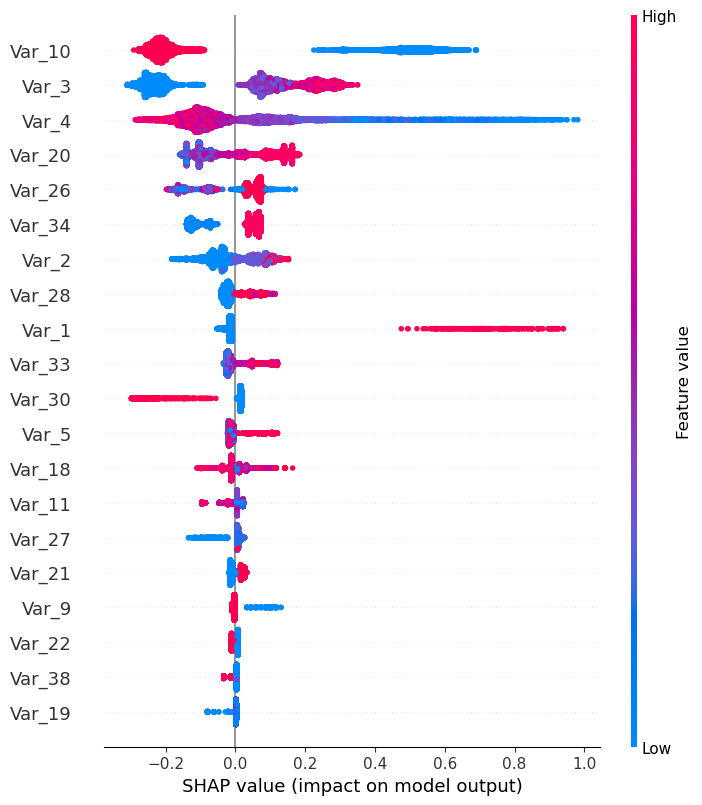

In [ ]:
shap.summary_plot(shap_values[1], X_resampled)

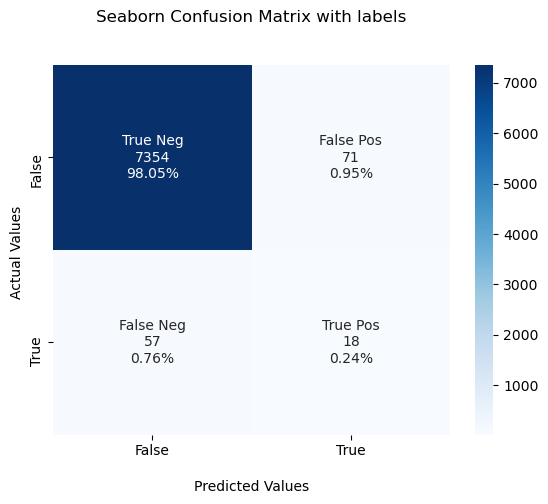

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm_test.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm_test.flatten()/np.sum(cm_test)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm_test, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

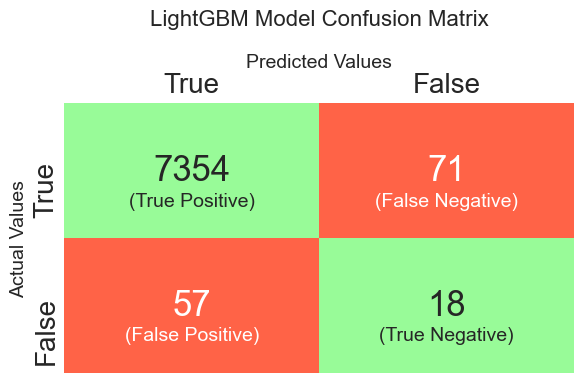

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set(style='white')

fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(np.eye(2), annot=cm_test, fmt='g', annot_kws={'size': 25},
            cmap=sns.color_palette(['tomato', 'palegreen'], as_cmap=True), cbar=False,
            yticklabels=['True', 'False'], xticklabels=['True', 'False'], ax=ax)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.tick_params(labelsize=20, length=0)

ax.set_title('LightGBM Model Confusion Matrix', size=16, pad=20)
ax.set_xlabel('Predicted Values', size=14)
ax.set_ylabel('Actual Values', size=14)

additional_texts = ['(True Positive)', '(False Negative)', '(False Positive)', '(True Negative)']
for text_elt, additional_text in zip(ax.texts, additional_texts):
    ax.text(*text_elt.get_position(), '\n' + additional_text, color=text_elt.get_color(),
            ha='center', va='top', size=14)
plt.tight_layout()
plt.show()

**Cluster Analysis**

In [30]:
y_test_predict_resampled_tuned_df = pd.DataFrame(data = y_test_predict_resampled_tuned, columns = ['Prediction' ], index=y_test.index)

In [31]:
y_test_predict_anomalies = y_test_predict_resampled_tuned_df[y_test['Target'] == 1]
y_test_anomalies = y_test[y_test['Target'] == 1]
X_test_anomalies = X_test[y_test['Target'] == 1]
X_test_anomalies_orig = X_test_orig[y_test['Target'] == 1]

In [36]:
y_test_anomalies.head()

,Target
index,
7146-Test,1
71198-Test,1
69005-Test,1
1284-Test,1
46229-Test,1


In [34]:
y_test_predict_anomalies.head()

,Prediction
index,
7146-Test,0
71198-Test,0
69005-Test,0
1284-Test,1
46229-Test,0


In [32]:
X_test_anomalies.head()

,Var_1,Var_2,Var_3,Var_4,Var_5,Var_6,Var_7,Var_8,Var_9,Var_10,Var_11,Var_12,Var_13,Var_14,Var_15,Var_18,Var_19,Var_20,Var_21,Var_22,Var_23,Var_25,Var_26,Var_27,Var_28,Var_30,Var_31,Var_33,Var_34,Var_36,Var_38,Var_39,Var_41
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7146-Test,-0.109742,-0.062630,0.347274,-0.524865,-1.627865,1.183906,0.480831,0.641715,0.194911,0.634267,-0.518619,-0.078538,-0.026559,-0.066270,0.517341,-0.270779,-0.271932,0.741682,0.401668,-0.755951,-0.116982,-0.064629,0.619527,0.063240,0.475470,-0.24908,0.240094,-0.396241,0.697147,-0.039831,-0.345385,-0.233373,-0.006544
71198-Test,-0.109742,4.979865,-0.153318,-1.912116,0.453430,-0.470549,0.480831,-1.558325,-5.130536,0.634267,-0.421199,-0.078538,-0.026559,-0.066270,0.517341,-0.181903,-0.271932,0.861147,-0.378395,-0.755951,-0.116982,-0.064629,-1.802960,-0.144079,15.181573,-0.24908,0.240094,-0.194869,-1.289230,-0.039831,-0.345385,-0.233373,-0.006544
69005-Test,-0.109742,-0.408430,-0.153318,1.845267,0.208486,1.183906,-2.079732,-1.558325,0.194911,-1.576622,-0.437615,-0.078538,-0.026559,-0.066270,0.517341,0.432227,-0.271932,-0.779227,-0.378395,1.322837,-0.116982,-0.064629,0.619527,-0.144079,-0.247141,-0.24908,0.240094,0.794689,-1.289230,-0.039831,-0.345385,-0.233373,-0.006544
1284-Test,9.112278,4.979865,-1.009085,-2.151195,1.669359,-0.470549,0.480831,0.641715,0.194911,0.634267,1.168140,-0.078538,-0.026559,16.925719,-1.932962,1.134248,-0.271932,-0.084203,8.463377,-0.755951,-0.116982,-0.064629,0.619527,-0.144079,15.181573,-0.24908,0.240094,0.318762,0.640053,-0.039831,2.917795,-0.233373,-0.006544
46229-Test,-0.109742,-0.062630,1.203042,-0.846589,-1.627865,-0.470549,0.480831,0.641715,0.194911,-1.576622,-0.368622,-0.078538,-0.026559,-0.066270,0.517341,-2.315973,-0.271932,0.741682,0.401668,-0.755951,-0.116982,-0.064629,0.619527,-0.144079,0.475470,-0.24908,0.240094,0.678273,-1.289230,-0.039831,-0.345385,-0.233373,-0.006544


In [22]:
X_test_anomalies_orig.head()

,Var_1,Var_2,Var_3,Var_4,Var_5,Var_6,Var_7,Var_8,Var_9,Var_10,Var_11,Var_12,Var_13,Var_14,Var_15,Var_18,Var_19,Var_20,Var_21,Var_22,Var_23,Var_24,Var_25,Var_26,Var_27,Var_28,Var_29,Var_30,Var_31,Var_33,Var_34,Var_35,Var_36,Var_37,Var_38,Var_39,Var_41
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7146-Test,0.0,0.009394,3.0,1057.0,0.0,2.0,1.0,1.0,1.0,1.0,1430.0,0.0,0.0,0.0,1.0,750.0,0.0,0.000000,0.014172,0.0,0.0,0.0,0.0,0.0000,0.010082,0.016504,0.0,0.0,0.010382,0.008804,0.011716,1.0,0.0,0.0,0.0,0.0,0.0
71198-Test,0.0,0.058156,2.0,587.0,642.0,0.0,1.0,0.0,0.0,1.0,1600.0,0.0,0.0,0.0,1.0,1000.0,0.0,1.154676,0.006070,0.0,0.0,0.0,0.0,0.1131,0.009814,0.217647,0.0,0.0,0.010382,0.009412,0.006826,0.0,0.0,0.0,0.0,0.0,0.0
69005-Test,0.0,0.006050,2.0,1860.0,300.0,2.0,0.0,0.0,1.0,0.0,1570.0,0.0,0.0,0.0,1.0,7300.0,0.0,0.160256,0.006070,1.0,0.0,0.0,0.0,0.0000,0.009814,0.006621,0.0,0.0,0.010382,0.012400,0.006826,0.0,0.0,0.0,0.0,0.0,0.0
1284-Test,1.0,0.058156,0.0,506.0,28038.0,0.0,1.0,1.0,1.0,1.0,10000.0,0.0,0.0,5.0,0.0,70827.0,0.0,0.369997,0.097902,0.0,0.0,0.0,0.0,0.0000,0.009814,0.217647,0.0,0.0,0.010382,0.010963,0.011576,1.0,0.0,0.0,23.5,0.0,0.0
46229-Test,0.0,0.009394,6.0,948.0,0.0,1.0,1.0,1.0,1.0,0.0,1700.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.014172,0.0,0.0,0.0,0.0,0.0000,0.009814,0.016504,0.0,0.0,0.010382,0.012048,0.006826,1.0,0.0,0.0,0.0,0.0,0.0


In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X_test_anomalies)

In [15]:
pca.explained_variance_ratio_.cumsum()

array([0.33837933, 0.55269874, 0.66836217, 0.72229027, 0.76991287])

In [19]:
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5' ], index=X_test_anomalies.index)

In [20]:
principalDf.head()

,PC1,PC2,PC3,PC4,PC5
index,,,,,
7146-Test,-3.221293,0.034023,-0.450897,0.350758,-0.088071
71198-Test,5.982013,-6.149664,-6.699450,6.070862,-1.570400
69005-Test,-4.312593,0.227042,-0.335894,0.891543,0.077892
1284-Test,17.847433,-9.234750,-0.484275,8.825322,-1.788277
46229-Test,-3.370713,0.141314,-0.559414,0.414479,-0.505708


In [23]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [45]:
kmeans = KMeans(
    init="random",
    n_clusters=2,
    n_init=10,
    max_iter=300,
    random_state=102022
)

In [46]:
kmeans.fit(principalDf)

KMeans(init='random', n_clusters=2, random_state=102022)

In [47]:
kmeans.labels_

array([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1])

In [48]:
df = pd.DataFrame(kmeans.labels_, columns = ['cluster'],index = X_test_anomalies.index)

In [49]:
df['Label'] = y_test_anomalies['Target']
df['Prediction'] = y_test_predict_anomalies['Prediction']

In [50]:
df.head()

,cluster,Label,Prediction
index,,,
7146-Test,1,1,0
71198-Test,0,1,0
69005-Test,1,1,0
1284-Test,0,1,1
46229-Test,1,1,0


In [54]:
df.groupby(['cluster', 'Prediction'])['Label'].count()

cluster  Prediction
0        0              2
         1             15
1        0             55
         1              3
Name: Label, dtype: int64

In [56]:
X_test_anomalies_orig['clusters'] = df['cluster']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [59]:
X_test_anomalies_orig_needed = X_test_anomalies_orig[['Var_1', 'Var_2', 'Var_3', 'Var_4', 'Var_5', 'Var_6', 'Var_7', 'Var_8',
       'Var_9', 'Var_10', 'Var_11', 'Var_12', 'Var_13', 'Var_14', 'Var_15',
       'Var_18', 'Var_19', 'Var_20', 'Var_21', 'Var_22', 'Var_23', 'Var_25',
       'Var_26', 'Var_27', 'Var_28', 'Var_30', 'Var_31', 'Var_33', 'Var_34',
       'Var_36', 'Var_38', 'Var_39','Var_41','clusters']]

In [60]:
X_test_anomalies_orig_needed.groupby(['clusters']).mean()

,Var_1,Var_2,Var_3,Var_4,Var_5,Var_6,Var_7,Var_8,Var_9,Var_10,Var_11,Var_12,Var_13,Var_14,Var_15,Var_18,Var_19,Var_20,Var_21,Var_22,Var_23,Var_25,Var_26,Var_27,Var_28,Var_30,Var_31,Var_33,Var_34,Var_36,Var_38,Var_39,Var_41
clusters,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.941176,0.055288,2.000000,472.941176,6647.529412,0.058824,0.941176,0.764706,0.941176,1.000000,8602.352941,1.647059,0.294118,0.941176,0.411765,32589.411765,223.405388,0.272548,0.056117,0.176471,0.294118,0.058824,0.362424,0.010162,0.106771,0.0,0.010382,0.009196,0.009929,8428.058824,12.919118,0.352941,0.235294
1,0.034483,0.010082,5.034483,1103.396552,991.189655,1.586207,0.741379,0.534483,0.913793,0.413793,2765.896552,0.000000,0.000000,0.000000,0.793103,6672.051724,2.136352,0.496136,0.010994,0.258621,0.000000,0.017241,0.017398,0.010216,0.011417,0.0,0.010219,0.010178,0.010574,0.000000,0.928986,0.017241,0.000000


In [63]:
from sklearn.manifold import TSNE

In [67]:
X_embedded = TSNE(n_components=2,
                init='random').fit_transform(X_test_anomalies_orig_needed[['Var_1', 'Var_2', 'Var_3', 'Var_4', 'Var_5', 'Var_6', 'Var_7', 'Var_8',
       'Var_9', 'Var_10', 'Var_11', 'Var_12', 'Var_13', 'Var_14', 'Var_15',
       'Var_18', 'Var_19', 'Var_20', 'Var_21', 'Var_22', 'Var_23', 'Var_25',
       'Var_26', 'Var_27', 'Var_28', 'Var_30', 'Var_31', 'Var_33', 'Var_34',
       'Var_36', 'Var_38', 'Var_39','Var_41']])
X_embedded.shape

(75, 2)

In [71]:
df_tsne = pd.DataFrame()
df_tsne["comp-1"] = X_embedded[:,0]
df_tsne["comp-2"] = X_embedded[:,1]

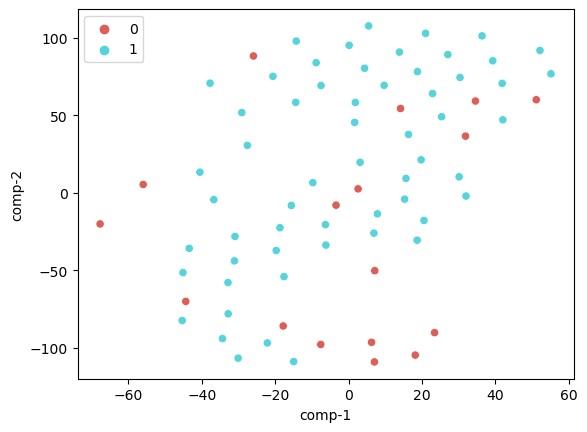

In [79]:
sns.scatterplot(x="comp-1", y="comp-2", hue=X_test_anomalies_orig_needed.clusters.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df_tsne)
plt.show()

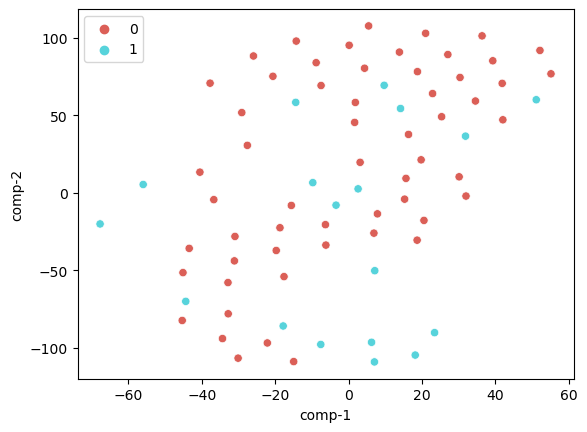

In [78]:
sns.scatterplot(x="comp-1", y="comp-2", hue=df.Prediction.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df_tsne)
plt.show()